In [9]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


Matplotlib is building the font cache; this may take a moment.


Loading data...
Data loaded with shape: (624, 1000)
Features shape: (624, 999)
Step 1: Computing similarity matrix...
Step 2: Identifying initial neighbors and densities...
Step 3: Preparing for cluster merging...
Step 4: Merging overlapping clusters...
Step 5: Refining clusters and handling outliers...

Clustering Results:
  Initial clusters: 607
  Final clusters: 35
  Total samples: 624
  Samples in clusters: 576
  Outliers: 48 (7.69%)

Cluster size distribution:
  Min size: 6
  Max size: 85
  Average size: 32.71
  Largest clusters: [85, 64, 62, 59, 55]


/var/folders/px/5k5grmpn7m1683gh7vt2xhsw0000gn/T/ipykernel_30128/4045263844.py:229: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


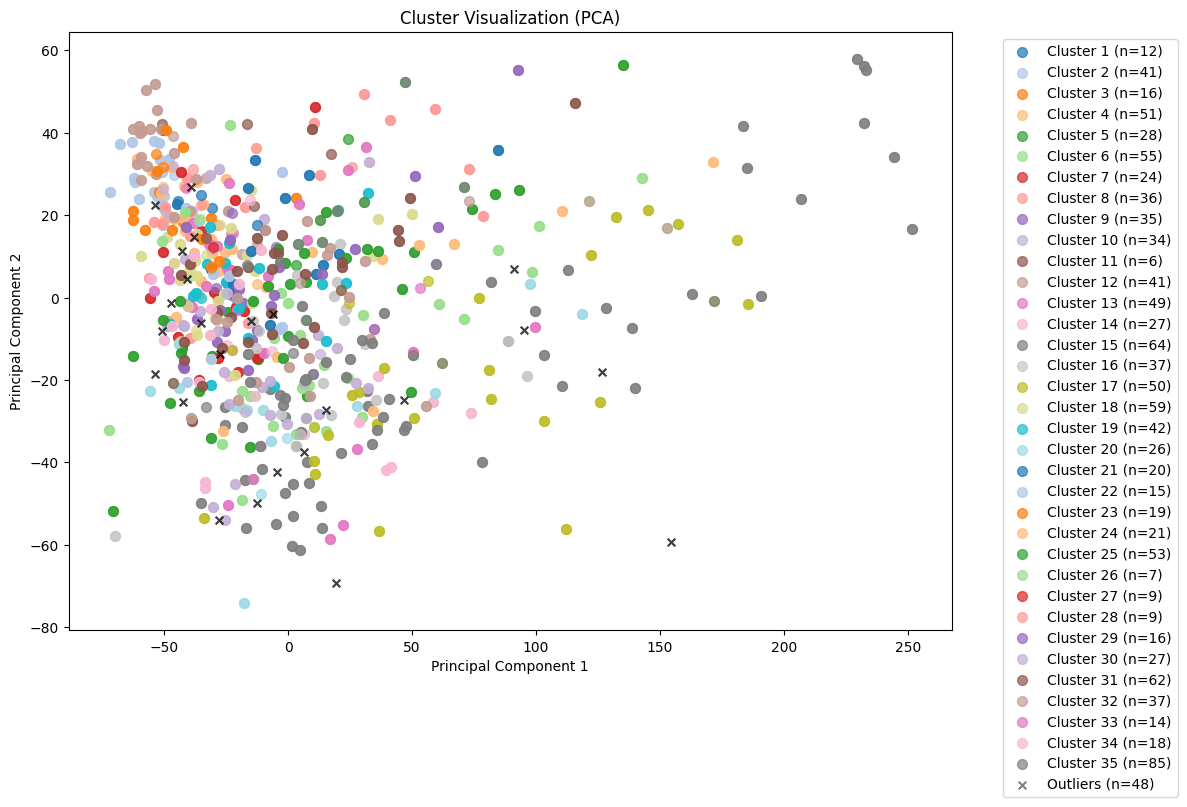

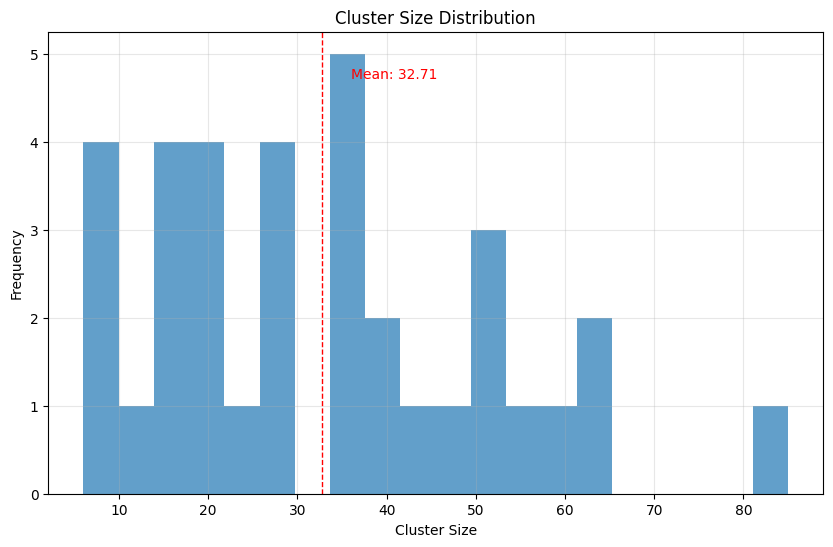


Evaluating clusters with provided labels:
Cluster 1: Label = 8.44, Purity = 0.17
Cluster 2: Label = 8.58, Purity = 0.05
Cluster 3: Label = 9.81, Purity = 0.12
Cluster 4: Label = 13.0, Purity = 0.04
Cluster 5: Label = 10.4, Purity = 0.07
Cluster 6: Label = 16.8, Purity = 0.04
Cluster 7: Label = 37.7, Purity = 0.08
Cluster 8: Label = 9.99, Purity = 0.06
Cluster 9: Label = 21.0, Purity = 0.09
Cluster 10: Label = 30.5, Purity = 0.06
Cluster 11: Label = 9.57, Purity = 0.33
Cluster 12: Label = 7.67, Purity = 0.10
Cluster 13: Label = 7.16, Purity = 0.08
Cluster 14: Label = 14.7, Purity = 0.07
Cluster 15: Label = 24.2, Purity = 0.06
Cluster 16: Label = 17.4, Purity = 0.11
Cluster 17: Label = 24.1, Purity = 0.04
Cluster 18: Label = 10.1, Purity = 0.07
Cluster 19: Label = 12.7, Purity = 0.05
Cluster 20: Label = 18.7, Purity = 0.08
Cluster 21: Label = 10.3, Purity = 0.20
Cluster 22: Label = 17.1, Purity = 0.13
Cluster 23: Label = 7.56, Purity = 0.16
Cluster 24: Label = 18.1, Purity = 0.10
Cluste

In [ ]:


# Function to normalize the data and compute similarity matrix
def normalized_euclidean_similarity(X):
    """ Compute (1 - normalized Euclidean distance) similarity matrix """
    # Normalize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Euclidean distances
    distances = cdist(X_scaled, X_scaled, metric='euclidean')
    
    # Normalize distances to [0, 1]
    max_dist = distances.max()
    normalized_dist = distances / max_dist
    
    # Convert to similarity
    similarity = 1 - normalized_dist
    return similarity

# Function to identify neighbors based on similarity threshold
def build_clusters(similarity_matrix, r=0.9):
    """ Identify neighbors based on similarity threshold and count densities """
    n_samples = similarity_matrix.shape[0]
    clusters = []
    densities = []
    
    for i in range(n_samples):
        neighbors = np.where(similarity_matrix[i] >= r)[0]
        clusters.append(neighbors)
        densities.append(len(neighbors))
    
    return clusters, densities

# Function to merge overlapping clusters
def merge_clusters(sample_info_sorted, threshold=0.5):
    """
    Merge clusters if they share more than `threshold` of the total number of samples.
    The merging will be based on the ratio of common samples to the total distinct samples.
    """
    merged = []
    visited = set()

    for i, density_i, cluster_i in sample_info_sorted:
        if i in visited:
            continue

        # Start new merged cluster
        merged_cluster = set(cluster_i)
        merged_indices = {i}
        visited.add(i)

        changed = True
        while changed:
            changed = False
            for j, density_j, cluster_j in sample_info_sorted:
                if j in visited:
                    continue

                set_j = set(cluster_j)
                common = merged_cluster.intersection(set_j)  # common samples
                union = merged_cluster.union(set_j)  # total distinct samples
                common_size = len(common)
                union_size = len(union)

                # Calculate the ratio of common samples to total distinct samples
                similarity_ratio = common_size / union_size if union_size > 0 else 0

                # Merge if similarity ratio exceeds threshold
                if similarity_ratio > threshold:
                    merged_cluster.update(set_j)
                    visited.add(j)
                    merged_indices.add(j)
                    changed = True

        merged.append(list(merged_cluster))

    return merged

# Function to remove outliers and assign samples to exactly one cluster
def remove_outliers_and_assign_unique_clusters(merged_clusters, similarity_matrix, outlier_threshold=0.75):
    """
    Refine clusters by:
    1. Removing duplicates (assigning each sample to exactly one cluster)
    2. Identifying and handling outliers
    3. Reassigning samples to their most appropriate cluster
    
    Parameters:
    - merged_clusters: List of clusters, where each cluster is a list of sample indices
    - similarity_matrix: Matrix of similarity scores between samples
    - outlier_threshold: Minimum average similarity a sample must have to its cluster
    
    Returns:
    - refined_clusters: List of refined clusters with unique sample assignments
    - cluster_assignments: Dictionary mapping sample index to assigned cluster index
    - outliers: List of outlier sample indices
    """
    n_samples = similarity_matrix.shape[0]
    
    # Initialize tracking variables
    cluster_assignments = {}  # Maps sample index to assigned cluster index
    assigned_samples = set()  # Tracks which samples have been assigned
    outliers = []  # List to store outlier samples
    refined_clusters = [[] for _ in range(len(merged_clusters))]
    
    # Sort clusters by size (descending) for stability - prioritize larger clusters
    sorted_clusters = sorted([(idx, cluster) for idx, cluster in enumerate(merged_clusters)], 
                            key=lambda x: len(x[1]), reverse=True)
    
    # First pass: Assign each sample to its most similar cluster when in multiple clusters
    for sample_idx in range(n_samples):
        # Find all clusters containing this sample
        containing_clusters = []
        for cluster_idx, (orig_idx, cluster) in enumerate(sorted_clusters):
            if sample_idx in cluster:
                containing_clusters.append((orig_idx, cluster))
        
        if not containing_clusters:
            # Sample isn't in any cluster yet - will handle in second pass
            continue
        
        # Calculate average similarity to each containing cluster
        best_cluster_idx = None
        best_avg_similarity = -1
        
        for orig_idx, cluster in containing_clusters:
            # Calculate average similarity to other samples in this cluster
            similarities = []
            for other_sample in cluster:
                if other_sample != sample_idx:  # Exclude self-similarity
                    similarities.append(similarity_matrix[sample_idx, other_sample])
            
            if similarities:  # Ensure cluster has other samples
                avg_similarity = sum(similarities) / len(similarities)
                if avg_similarity > best_avg_similarity:
                    best_avg_similarity = avg_similarity
                    best_cluster_idx = orig_idx
        
        # Check if the sample is an outlier based on similarity threshold
        if best_avg_similarity < outlier_threshold:
            outliers.append(sample_idx)
        else:
            # Assign sample to its best-fitting cluster
            cluster_assignments[sample_idx] = best_cluster_idx
            refined_clusters[best_cluster_idx].append(sample_idx)
            assigned_samples.add(sample_idx)
    
    # Second pass: Handle unassigned samples (not in any initial cluster)
    unassigned = set(range(n_samples)) - assigned_samples
    
    for sample_idx in unassigned:
        # Find the cluster with highest average similarity
        best_cluster_idx = None
        best_avg_similarity = -1
        
        for cluster_idx, cluster in enumerate(refined_clusters):
            if not cluster:  # Skip empty clusters
                continue
                
            # Calculate average similarity to this cluster
            similarities = [similarity_matrix[sample_idx, other_sample] for other_sample in cluster]
            if similarities:
                avg_similarity = sum(similarities) / len(similarities)
                if avg_similarity > best_avg_similarity:
                    best_avg_similarity = avg_similarity
                    best_cluster_idx = cluster_idx
        
        # Check if sample should be an outlier
        if best_avg_similarity < outlier_threshold:
            outliers.append(sample_idx)
        else:
            # Assign to best cluster
            cluster_assignments[sample_idx] = best_cluster_idx
            refined_clusters[best_cluster_idx].append(sample_idx)
            assigned_samples.add(sample_idx)
    
    # Final pass: Try to reassign outliers to the most similar cluster with relaxed threshold
    for outlier_idx in outliers.copy():  # Use copy to allow modification during iteration
        best_cluster_idx = None
        best_avg_similarity = -1
        
        for cluster_idx, cluster in enumerate(refined_clusters):
            if not cluster:  # Skip empty clusters
                continue
                
            # Calculate average similarity to this cluster
            similarities = [similarity_matrix[outlier_idx, other_sample] for other_sample in cluster]
            if similarities:
                avg_similarity = sum(similarities) / len(similarities)
                if avg_similarity > best_avg_similarity:
                    best_avg_similarity = avg_similarity
                    best_cluster_idx = cluster_idx
        
        # Use a more lenient threshold for outlier reassignment
        relaxed_threshold = outlier_threshold * 0.8
        if best_avg_similarity >= relaxed_threshold:
            cluster_assignments[outlier_idx] = best_cluster_idx
            refined_clusters[best_cluster_idx].append(outlier_idx)
            outliers.remove(outlier_idx)
    
    # Remove empty clusters
    final_clusters = []
    final_assignments = {}
    
    for new_idx, cluster in enumerate([c for c in refined_clusters if c]):
        final_clusters.append(cluster)
        for sample in cluster:
            final_assignments[sample] = new_idx
    
    return final_clusters, final_assignments, outliers

# Function to visualize clustering results
def visualize_clustering_results(data, final_clusters, outliers, cluster_assignments):
    """
    Visualize the clustering results using dimensionality reduction
    """
    # Use PCA to reduce dimensions for visualization
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    
    # Create a colormap for the clusters
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab20')
    colors = [cmap(i % 20) for i in range(len(final_clusters))]
    
    # Plot clusters and outliers
    plt.figure(figsize=(12, 8))
    
    # Plot each cluster
    for idx, cluster in enumerate(final_clusters):
        if len(cluster) > 0:
            cluster_points = data_2d[cluster]
            plt.scatter(
                cluster_points[:, 0], 
                cluster_points[:, 1], 
                color=colors[idx], 
                alpha=0.7, 
                s=50, 
                label=f'Cluster {idx+1} (n={len(cluster)})'
            )
    
    # Plot outliers
    if outliers:
        outlier_points = data_2d[outliers]
        plt.scatter(
            outlier_points[:, 0], 
            outlier_points[:, 1], 
            color='black', 
            marker='x', 
            alpha=0.5, 
            s=30, 
            label=f'Outliers (n={len(outliers)})'
        )
    
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1)
    plt.tight_layout()
    plt.show()
    
    # Plot cluster size distribution
    cluster_sizes = [len(cluster) for cluster in final_clusters]
    plt.figure(figsize=(10, 6))
    plt.hist(cluster_sizes, bins=20, alpha=0.7)
    plt.axvline(np.mean(cluster_sizes), color='r', linestyle='dashed', linewidth=1)
    plt.text(
        np.mean(cluster_sizes)*1.1, 
        plt.ylim()[1]*0.9, 
        f'Mean: {np.mean(cluster_sizes):.2f}', 
        color='r'
    )
    plt.title('Cluster Size Distribution')
    plt.xlabel('Cluster Size')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()

# Main function to run the improved clustering pipeline
def improved_clustering_pipeline(data, initial_r=0.862, merge_threshold=0.5, outlier_threshold=0.75):
    """
    Enhanced clustering pipeline that ensures each sample belongs to exactly one cluster
    and handles outliers appropriately.
    """
    print("Step 1: Computing similarity matrix...")
    similarity = normalized_euclidean_similarity(data)
    
    print("Step 2: Identifying initial neighbors and densities...")
    clusters, densities = build_clusters(similarity, r=initial_r)
    
    print("Step 3: Preparing for cluster merging...")
    sample_info = [(i, densities[i], clusters[i]) for i in range(len(clusters))]
    sample_info_sorted = sorted(sample_info, key=lambda x: x[1], reverse=True)
    
    print("Step 4: Merging overlapping clusters...")
    merged_clusters = merge_clusters(sample_info_sorted, threshold=merge_threshold)
    
    print("Step 5: Refining clusters and handling outliers...")
    final_clusters, cluster_assignments, outliers = remove_outliers_and_assign_unique_clusters(
        merged_clusters, similarity, outlier_threshold=outlier_threshold
    )
    
    # Print summary statistics
    print(f"\nClustering Results:")
    print(f"  Initial clusters: {len(merged_clusters)}")
    print(f"  Final clusters: {len(final_clusters)}")
    print(f"  Total samples: {data.shape[0]}")
    print(f"  Samples in clusters: {data.shape[0] - len(outliers)}")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/data.shape[0]*100:.2f}%)")
    
    # Show cluster size distribution
    cluster_sizes = [len(cluster) for cluster in final_clusters]
    print(f"\nCluster size distribution:")
    print(f"  Min size: {min(cluster_sizes) if cluster_sizes else 0}")
    print(f"  Max size: {max(cluster_sizes) if cluster_sizes else 0}")
    print(f"  Average size: {sum(cluster_sizes)/len(cluster_sizes) if cluster_sizes else 0:.2f}")
    print(f"  Largest clusters: {sorted(cluster_sizes, reverse=True)[:5]}")
    
    return final_clusters, cluster_assignments, outliers, similarity

# Function to evaluate clustering results
def evaluate_clusters(final_clusters, outliers, labels):
    """
    Evaluate the quality of clusters using known labels (if available)
    """
    # Create a mapping of cluster_idx to most common label in that cluster
    from collections import Counter
    
    cluster_labels = {}
    for cluster_idx, cluster in enumerate(final_clusters):
        if cluster:
            cluster_label_counts = Counter([labels[sample_idx] for sample_idx in cluster])
            most_common_label = cluster_label_counts.most_common(1)[0][0]
            cluster_labels[cluster_idx] = most_common_label
            
            # Calculate purity (% of samples with most common label)
            purity = cluster_label_counts[most_common_label] / len(cluster)
            print(f"Cluster {cluster_idx+1}: Label = {most_common_label}, Purity = {purity:.2f}")
    
    # Calculate overall purity
    correct_assignments = 0
    total_in_clusters = 0
    
    for cluster_idx, cluster in enumerate(final_clusters):
        if cluster:
            cluster_label = cluster_labels[cluster_idx]
            correct_in_cluster = sum(1 for sample_idx in cluster if labels[sample_idx] == cluster_label)
            correct_assignments += correct_in_cluster
            total_in_clusters += len(cluster)
    
    overall_purity = correct_assignments / total_in_clusters if total_in_clusters > 0 else 0
    print(f"\nOverall cluster purity: {overall_purity:.2f}")
    
    # Check outliers
    if outliers:
        outlier_label_counts = Counter([labels[sample_idx] for sample_idx in outliers])
        print("\nOutlier distribution:")
        for label, count in outlier_label_counts.most_common():
            print(f"  Label {label}: {count} samples ({count/len(outliers)*100:.2f}%)")

# Main execution function
def run_clustering_analysis():
    # Load your data - using your CSV file path 
    print("Loading data...")
    data = pd.read_csv("../data/vpufs_reduced_features.csv")
    
    # Data preprocessing as in your original code
    data = data.dropna(axis=1)
    data = data.loc[:, ~data.columns.duplicated()]
    data = data.apply(pd.to_numeric, errors='coerce')
    data = data.dropna()
    
    # Extract labels and features
    labels = data.iloc[:, -1].values
    features_df = data.drop(data.columns[-1], axis=1)
    
    print(f"Data loaded with shape: {data.shape}")
    print(f"Features shape: {features_df.shape}")
    
    # Run the clustering pipeline
    final_clusters, cluster_assignments, outliers, similarity = improved_clustering_pipeline(
        features_df,
        initial_r=0.862,        # Initial similarity threshold
        merge_threshold=0.5,    # Threshold for merging clusters  
        outlier_threshold=0.75  # Threshold for identifying outliers
    )
    
    # Visualize the results (if matplotlib is available)
    try:
        visualize_clustering_results(features_df.values, final_clusters, outliers, cluster_assignments)
    except ImportError:
        print("Visualization libraries not available. Skipping visualization.")
    
    # Evaluate clustering (if labels are available)
    if labels is not None and len(labels) > 0:
        print("\nEvaluating clusters with provided labels:")
        evaluate_clusters(final_clusters, outliers, labels)
    
    # Save results to CSV
    save_results_to_csv(data, final_clusters, outliers, cluster_assignments)
    
    return final_clusters, cluster_assignments, outliers, similarity

def save_results_to_csv(data, final_clusters, outliers, cluster_assignments):
    """Save clustering results to CSV files"""
    # Create DataFrame with original data and cluster assignments
    result_df = data.copy()
    
    # Add cluster assignment column
    cluster_column = [-1] * len(data)  # Initialize all to -1 (outlier)
    for sample_idx, cluster_idx in cluster_assignments.items():
        cluster_column[sample_idx] = cluster_idx
    
    result_df['cluster'] = cluster_column
    
    # Save to CSV
    result_df.to_csv("clustering_results.csv", index=False)
    print("Results saved to 'clustering_results.csv'")
    
    # Save cluster summary
    cluster_summary = []
    for cluster_idx, cluster in enumerate(final_clusters):
        cluster_summary.append({
            'cluster_id': cluster_idx,
            'size': len(cluster),
            'samples': str(sorted(cluster))
        })
    
    summary_df = pd.DataFrame(cluster_summary)
    summary_df.to_csv("cluster_summary.csv", index=False)
    print("Cluster summary saved to 'cluster_summary.csv'")


# Run the analysis if the script is executed directly
if __name__ == "__main__":
    final_clusters, cluster_assignments, outliers, similarity = run_clustering_analysis()
    

Loading data...
Data loaded with shape: (624, 1000)
Features shape: (624, 999)
Step 1: Computing similarity matrix...
Step 2: Identifying initial neighbors and densities...
Step 3: Preparing for cluster merging...
Step 4: Merging overlapping clusters...
Step 5: Refining clusters and handling outliers...
Step 6: Consolidating small clusters...

Clustering Results:
  Initial clusters: 363
  Refined clusters: 115
  Final clusters: 11
  Total samples: 624
  Samples in clusters: 614
  Outliers: 10 (1.60%)

Cluster size distribution:
  Min size: 4
  Max size: 620
  Average size: 76.73
  Cluster sizes: [620, 74, 42, 36, 24, 16, 11, 8, 5, 4, 4]


/var/folders/px/5k5grmpn7m1683gh7vt2xhsw0000gn/T/ipykernel_30128/2710747079.py:328: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')  # Using tab10 instead of tab20 for fewer, more distinct colors


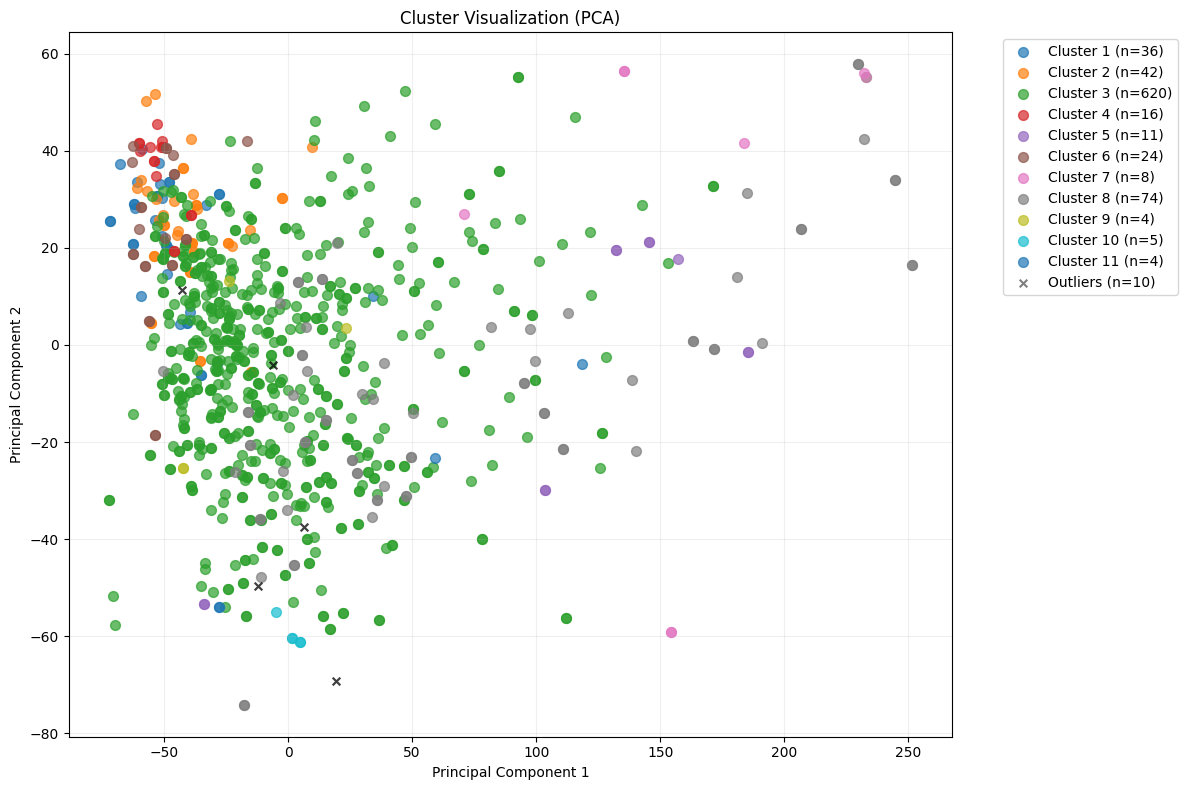

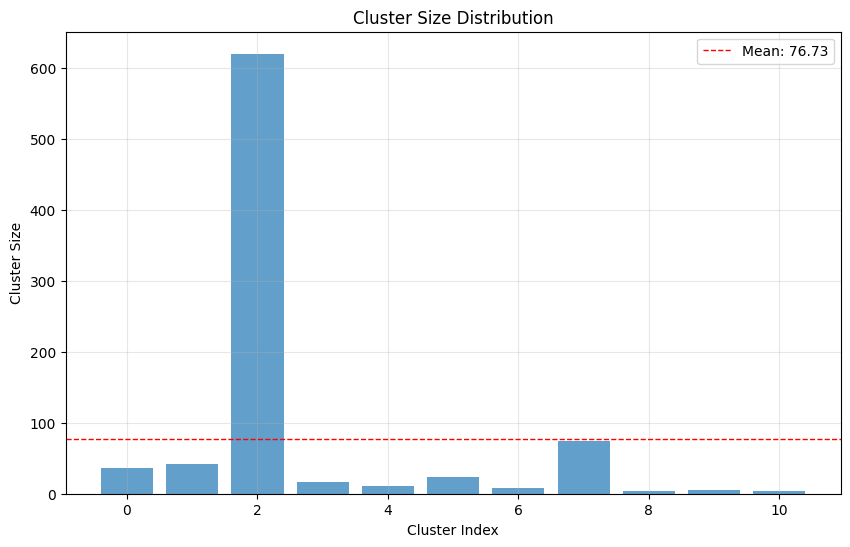


Evaluating clusters with provided labels:
Cluster 1: Label = 6.75, Purity = 0.06
Cluster 2: Label = 12.5, Purity = 0.10
Cluster 3: Label = 11.4, Purity = 0.01
Cluster 4: Label = 8.65, Purity = 0.12
Cluster 5: Label = 22.7, Purity = 0.18
Cluster 6: Label = 7.07, Purity = 0.08
Cluster 7: Label = 11.2, Purity = 0.25
Cluster 8: Label = 17.5, Purity = 0.04
Cluster 9: Label = 13.2, Purity = 0.50
Cluster 10: Label = 55.0, Purity = 0.40
Cluster 11: Label = 26.6, Purity = 0.50

Overall cluster purity: 0.04

Outlier distribution:
  Label 21.5: 2 samples (20.00%)
  Label 36.0: 2 samples (20.00%)
  Label 108.0: 2 samples (20.00%)
  Label 7.0: 2 samples (20.00%)
  Label 7.89: 2 samples (20.00%)
Results saved to 'clustering_results.csv'
Cluster summary saved to 'cluster_summary.csv'


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to normalize the data and compute similarity matrix
def normalized_euclidean_similarity(X):
    """ Compute (1 - normalized Euclidean distance) similarity matrix """
    # Normalize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Euclidean distances
    distances = cdist(X_scaled, X_scaled, metric='euclidean')
    
    # Normalize distances to [0, 1]
    max_dist = distances.max()
    normalized_dist = distances / max_dist
    
    # Convert to similarity
    similarity = 1 - normalized_dist
    return similarity

# Function to identify neighbors based on similarity threshold
def build_clusters(similarity_matrix, r=0.8):  # Reduced from 0.9 to 0.8
    """ Identify neighbors based on similarity threshold and count densities """
    n_samples = similarity_matrix.shape[0]
    clusters = []
    densities = []
    
    for i in range(n_samples):
        neighbors = np.where(similarity_matrix[i] >= r)[0]
        clusters.append(neighbors)
        densities.append(len(neighbors))
    
    return clusters, densities



# 2. Fix the hierarchical_cluster_merging function
def hierarchical_cluster_merging(clusters, similarity_matrix, initial_threshold=0.45, min_threshold=0.35, step=0.03):
    """
    Hierarchical merging of clusters with better control
    """
    if len(clusters) <= 4:  # If already few clusters, no need to merge
        return clusters
    
    merged = clusters.copy()
    current_threshold = initial_threshold
    
    # CHANGE: Add maximum iterations to prevent over-merging
    max_iterations = 5
    iteration = 0
    
    while current_threshold >= min_threshold and len(merged) > 4 and iteration < max_iterations:
        prev_count = len(merged)
        # Try to merge at current threshold
        merged = merge_overlapping_clusters(merged, similarity_matrix, current_threshold)
        
        # CHANGE: Break if no more merging is happening
        if len(merged) == prev_count:
            break
            
        # If we still have too many clusters, reduce threshold and try again
        if len(merged) > 10:
            current_threshold -= step
        else:
            break
        
        iteration += 1
    
    return merged

# New function to further consolidate small clusters
def consolidate_small_clusters(clusters, similarity_matrix, min_cluster_size=15, similarity_threshold=0.6):
    """
    Further consolidate small clusters based on average inter-cluster similarity
    """
    # Identify small clusters
    small_clusters = [idx for idx, cluster in enumerate(clusters) if len(cluster) < min_cluster_size]
    large_clusters = [idx for idx, cluster in enumerate(clusters) if len(cluster) >= min_cluster_size]
    
    # If no small clusters or no large clusters, return original clusters
    if not small_clusters or not large_clusters:
        return clusters
    
    # Calculate average inter-cluster similarity
    new_clusters = [clusters[idx].copy() for idx in range(len(clusters))]
    
    # Try to merge each small cluster with the most similar large cluster
    for small_idx in small_clusters:
        best_merge_idx = None
        best_similarity = -1
        
        small_cluster = clusters[small_idx]
        
        # Find most similar large cluster
        for large_idx in large_clusters:
            large_cluster = clusters[large_idx]
            
            # Calculate average similarity between clusters
            total_sim = 0
            count = 0
            
            for s_idx in small_cluster:
                for l_idx in large_cluster:
                    total_sim += similarity_matrix[s_idx, l_idx]
                    count += 1
            
            avg_sim = total_sim / count if count > 0 else 0
            
            if avg_sim > best_similarity:
                best_similarity = avg_sim
                best_merge_idx = large_idx
        
        # Merge if similarity is above threshold
        if best_merge_idx is not None and best_similarity >= similarity_threshold:
            new_clusters[best_merge_idx].extend(small_cluster)
            new_clusters[small_idx] = []  # Empty this cluster
    
    # Remove empty clusters
    final_clusters = [cluster for cluster in new_clusters if cluster]
    
    return final_clusters

# Function to remove outliers and assign samples to exactly one cluster
def remove_outliers_and_assign_unique_clusters(merged_clusters, similarity_matrix, outlier_threshold=0.65):  # Reduced from 0.75 to 0.65
    """
    Refine clusters by:
    1. Removing duplicates (assigning each sample to exactly one cluster)
    2. Identifying and handling outliers
    3. Reassigning samples to their most appropriate cluster
    """
    n_samples = similarity_matrix.shape[0]
    
    # Initialize tracking variables
    cluster_assignments = {}  # Maps sample index to assigned cluster index
    assigned_samples = set()  # Tracks which samples have been assigned
    outliers = []  # List to store outlier samples
    refined_clusters = [[] for _ in range(len(merged_clusters))]
    
    # Sort clusters by size (descending) for stability - prioritize larger clusters
    sorted_clusters = sorted([(idx, cluster) for idx, cluster in enumerate(merged_clusters)], 
                            key=lambda x: len(x[1]), reverse=True)
    
    # First pass: Assign each sample to its most similar cluster when in multiple clusters
    for sample_idx in range(n_samples):
        # Find all clusters containing this sample
        containing_clusters = []
        for cluster_idx, (orig_idx, cluster) in enumerate(sorted_clusters):
            if sample_idx in cluster:
                containing_clusters.append((orig_idx, cluster))
        
        if not containing_clusters:
            # Sample isn't in any cluster yet - will handle in second pass
            continue
        
        # Calculate average similarity to each containing cluster
        best_cluster_idx = None
        best_avg_similarity = -1
        
        for orig_idx, cluster in containing_clusters:
            # Calculate average similarity to other samples in this cluster
            similarities = []
            for other_sample in cluster:
                if other_sample != sample_idx:  # Exclude self-similarity
                    similarities.append(similarity_matrix[sample_idx, other_sample])
            
            if similarities:  # Ensure cluster has other samples
                avg_similarity = sum(similarities) / len(similarities)
                if avg_similarity > best_avg_similarity:
                    best_avg_similarity = avg_similarity
                    best_cluster_idx = orig_idx
        
        # Check if the sample is an outlier based on similarity threshold
        if best_avg_similarity < outlier_threshold:
            outliers.append(sample_idx)
        else:
            # Assign sample to its best-fitting cluster
            cluster_assignments[sample_idx] = best_cluster_idx
            refined_clusters[best_cluster_idx].append(sample_idx)
            assigned_samples.add(sample_idx)
    
    # Second pass: Handle unassigned samples (not in any initial cluster)
    unassigned = set(range(n_samples)) - assigned_samples
    
    for sample_idx in unassigned:
        # Find the cluster with highest average similarity
        best_cluster_idx = None
        best_avg_similarity = -1
        
        for cluster_idx, cluster in enumerate(refined_clusters):
            if not cluster:  # Skip empty clusters
                continue
                
            # Calculate average similarity to this cluster
            similarities = [similarity_matrix[sample_idx, other_sample] for other_sample in cluster]
            if similarities:
                avg_similarity = sum(similarities) / len(similarities)
                if avg_similarity > best_avg_similarity:
                    best_avg_similarity = avg_similarity
                    best_cluster_idx = cluster_idx
        
        # Use a lower threshold for unassigned samples
        if best_avg_similarity < (outlier_threshold * 0.9):
            outliers.append(sample_idx)
        else:
            # Assign to best cluster
            cluster_assignments[sample_idx] = best_cluster_idx
            refined_clusters[best_cluster_idx].append(sample_idx)
            assigned_samples.add(sample_idx)
    
    # Final pass: Try to reassign outliers to the most similar cluster with relaxed threshold
    for outlier_idx in outliers.copy():  # Use copy to allow modification during iteration
        best_cluster_idx = None
        best_avg_similarity = -1
        
        for cluster_idx, cluster in enumerate(refined_clusters):
            if not cluster:  # Skip empty clusters
                continue
                
            # Calculate average similarity to this cluster
            similarities = [similarity_matrix[outlier_idx, other_sample] for other_sample in cluster]
            if similarities:
                avg_similarity = sum(similarities) / len(similarities)
                if avg_similarity > best_avg_similarity:
                    best_avg_similarity = avg_similarity
                    best_cluster_idx = cluster_idx
        
        # Use an even more relaxed threshold for outlier reassignment
        relaxed_threshold = outlier_threshold * 0.6  # More aggressive reassignment
        if best_avg_similarity >= relaxed_threshold:
            cluster_assignments[outlier_idx] = best_cluster_idx
            refined_clusters[best_cluster_idx].append(outlier_idx)
            outliers.remove(outlier_idx)
    
    # Remove empty clusters
    final_clusters = []
    final_assignments = {}
    
    for new_idx, cluster in enumerate([c for c in refined_clusters if c]):
        final_clusters.append(cluster)
        for sample in cluster:
            final_assignments[sample] = new_idx
    
    return final_clusters, final_assignments, outliers

# Main function to run the improved clustering pipeline
# 1. Adjust these parameters in improved_clustering_pipeline function
def improved_clustering_pipeline(data, target_clusters=6):
    print("Step 1: Computing similarity matrix...")
    similarity = normalized_euclidean_similarity(data)
    
    # CHANGE: Reduce initial similarity threshold to form fewer initial clusters
    print("Step 2: Building initial clusters...")
    initial_clusters, densities = build_initial_clusters(similarity, r=0.80)  # Changed from 0.85
    
    print("Step 3: Merging overlapping clusters...")
    # CHANGE: Use more conservative merging thresholds
    merged_clusters = hierarchical_cluster_merging(initial_clusters, similarity,
                                                initial_threshold=0.45,  # Changed from 0.4
                                                min_threshold=0.35,      # Changed from 0.2
                                                step=0.03)               # Changed from 0.05
    

    
    print("Step 5: Refining clusters and handling outliers...")
    refined_clusters, cluster_assignments, outliers = remove_outliers_and_assign_unique_clusters(
        merged_clusters, similarity, outlier_threshold=outlier_threshold
    )
    
    print("Step 6: Consolidating small clusters...")
    consolidated_clusters = consolidate_small_clusters(
        refined_clusters, similarity, 
        min_cluster_size=min_cluster_size, 
        similarity_threshold=second_merge_threshold
    )
    
    # Update assignments based on consolidated clusters
    final_assignments = {}
    for cluster_idx, cluster in enumerate(consolidated_clusters):
        for sample_idx in cluster:
            final_assignments[sample_idx] = cluster_idx
    
    # Print summary statistics
    print(f"\nClustering Results:")
    print(f"  Initial clusters: {len(merged_clusters)}")
    print(f"  Refined clusters: {len(refined_clusters)}")
    print(f"  Final clusters: {len(consolidated_clusters)}")
    print(f"  Total samples: {data.shape[0]}")
    print(f"  Samples in clusters: {data.shape[0] - len(outliers)}")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/data.shape[0]*100:.2f}%)")
    
    # Show cluster size distribution
    cluster_sizes = [len(cluster) for cluster in consolidated_clusters]
    print(f"\nCluster size distribution:")
    print(f"  Min size: {min(cluster_sizes) if cluster_sizes else 0}")
    print(f"  Max size: {max(cluster_sizes) if cluster_sizes else 0}")
    print(f"  Average size: {sum(cluster_sizes)/len(cluster_sizes) if cluster_sizes else 0:.2f}")
    print(f"  Cluster sizes: {sorted(cluster_sizes, reverse=True)}")
    
    return consolidated_clusters, final_assignments, outliers, similarity

# Function to visualize clustering results
def visualize_clustering_results(data, final_clusters, outliers, cluster_assignments):
    """
    Visualize the clustering results using dimensionality reduction
    """
    # Use PCA to reduce dimensions for visualization
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    
    # Create a colormap for the clusters
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab10')  # Using tab10 instead of tab20 for fewer, more distinct colors
    colors = [cmap(i % 10) for i in range(len(final_clusters))]
    
    # Plot clusters and outliers
    plt.figure(figsize=(12, 8))
    
    # Plot each cluster
    for idx, cluster in enumerate(final_clusters):
        if len(cluster) > 0:
            cluster_points = data_2d[cluster]
            plt.scatter(
                cluster_points[:, 0], 
                cluster_points[:, 1], 
                color=colors[idx], 
                alpha=0.7, 
                s=50, 
                label=f'Cluster {idx+1} (n={len(cluster)})'
            )
    
    # Plot outliers
    if outliers:
        outlier_points = data_2d[outliers]
        plt.scatter(
            outlier_points[:, 0], 
            outlier_points[:, 1], 
            color='black', 
            marker='x', 
            alpha=0.5, 
            s=30, 
            label=f'Outliers (n={len(outliers)})'
        )
    
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1)
    plt.tight_layout()
    plt.grid(alpha=0.2)
    plt.show()
    
    # Plot cluster size distribution
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(final_clusters)), [len(c) for c in final_clusters], alpha=0.7)
    plt.axhline(np.mean([len(c) for c in final_clusters]), 
               color='r', linestyle='dashed', linewidth=1,
               label=f'Mean: {np.mean([len(c) for c in final_clusters]):.2f}')
    plt.xlabel('Cluster Index')
    plt.ylabel('Cluster Size')
    plt.title('Cluster Size Distribution')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Main execution function
def run_clustering_analysis():
    # Load your data - using your CSV file path 
    print("Loading data...")
    data = pd.read_csv("../data/vpufs_reduced_features.csv")
    
    # Data preprocessing as in your original code
    data = data.dropna(axis=1)
    data = data.loc[:, ~data.columns.duplicated()]
    data = data.apply(pd.to_numeric, errors='coerce')
    data = data.dropna()
    
    # Extract labels and features
    labels = data.iloc[:, -1].values
    features_df = data.drop(data.columns[-1], axis=1)
    
    print(f"Data loaded with shape: {data.shape}")
    print(f"Features shape: {features_df.shape}")
    
    # Run the clustering pipeline with adjusted parameters
    final_clusters, cluster_assignments, outliers, similarity = improved_clustering_pipeline(
        features_df,
        initial_r=0.8,             # Reduced from 0.862 to create larger initial clusters
        merge_threshold=0.3,       # Reduced from 0.5 to merge clusters more aggressively
        outlier_threshold=0.65,    # Reduced from 0.75 to be less strict about outliers
        min_cluster_size=15,       # Min size for a standalone cluster
        second_merge_threshold=0.6 # Threshold for second round of merging
    )
    
    # Visualize the results
    try:
        visualize_clustering_results(features_df.values, final_clusters, outliers, cluster_assignments)
    except ImportError:
        print("Visualization libraries not available. Skipping visualization.")
    
    # Evaluate clustering (if labels are available)
    if labels is not None and len(labels) > 0:
        print("\nEvaluating clusters with provided labels:")
        evaluate_clusters(final_clusters, outliers, labels)
    
    # Save results to CSV
    save_results_to_csv(data, final_clusters, outliers, cluster_assignments)
    
    return final_clusters, cluster_assignments, outliers, similarity

def evaluate_clusters(final_clusters, outliers, labels):
    """
    Evaluate the quality of clusters using known labels (if available)
    """
    from collections import Counter
    
    cluster_labels = {}
    for cluster_idx, cluster in enumerate(final_clusters):
        if cluster:
            cluster_label_counts = Counter([labels[sample_idx] for sample_idx in cluster])
            most_common_label = cluster_label_counts.most_common(1)[0][0]
            cluster_labels[cluster_idx] = most_common_label
            
            # Calculate purity (% of samples with most common label)
            purity = cluster_label_counts[most_common_label] / len(cluster)
            print(f"Cluster {cluster_idx+1}: Label = {most_common_label}, Purity = {purity:.2f}")
    
    # Calculate overall purity
    correct_assignments = 0
    total_in_clusters = 0
    
    for cluster_idx, cluster in enumerate(final_clusters):
        if cluster:
            cluster_label = cluster_labels[cluster_idx]
            correct_in_cluster = sum(1 for sample_idx in cluster if labels[sample_idx] == cluster_label)
            correct_assignments += correct_in_cluster
            total_in_clusters += len(cluster)
    
    overall_purity = correct_assignments / total_in_clusters if total_in_clusters > 0 else 0
    print(f"\nOverall cluster purity: {overall_purity:.2f}")
    
    # Check outliers
    if outliers:
        outlier_label_counts = Counter([labels[sample_idx] for sample_idx in outliers])
        print("\nOutlier distribution:")
        for label, count in outlier_label_counts.most_common():
            print(f"  Label {label}: {count} samples ({count/len(outliers)*100:.2f}%)")

def save_results_to_csv(data, final_clusters, outliers, cluster_assignments):
    """Save clustering results to CSV files"""
    # Create DataFrame with original data and cluster assignments
    result_df = data.copy()
    
    # Add cluster assignment column
    cluster_column = [-1] * len(data)  # Initialize all to -1 (outlier)
    for sample_idx, cluster_idx in cluster_assignments.items():
        cluster_column[sample_idx] = cluster_idx
    
    result_df['cluster'] = cluster_column
    
    # Save to CSV
    result_df.to_csv("clustering_results.csv", index=False)
    print("Results saved to 'clustering_results.csv'")
    
    # Save cluster summary
    cluster_summary = []
    for cluster_idx, cluster in enumerate(final_clusters):
        cluster_summary.append({
            'cluster_id': cluster_idx,
            'size': len(cluster),
            'samples': str(sorted(cluster))
        })
    
    summary_df = pd.DataFrame(cluster_summary)
    summary_df.to_csv("cluster_summary.csv", index=False)
    print("Cluster summary saved to 'cluster_summary.csv'")

# Run the analysis if the script is executed directly
if __name__ == "__main__":
    final_clusters, cluster_assignments, outliers, similarity = run_clustering_analysis()

# Another method

Loading data...
Data loaded with shape: (624, 1000)
Features shape: (624, 999)
Step 1: Computing similarity matrix...
Step 2: Building initial clusters...
Step 3: Merging overlapping clusters...
Step 4: Balancing cluster sizes...
Step 5: Assigning samples to best-fitting clusters...

Clustering Results:
  Initial clusters: 624
  After merging: 7
  After balancing: 3
  Final clusters: 3
  Total samples: 624
  Samples in clusters: 618
  Outliers: 6 (0.96%)

Cluster size distribution:
  Min size: 68
  Max size: 482
  Average size: 206.00
  Cluster sizes: [482, 68, 68]


/var/folders/px/5k5grmpn7m1683gh7vt2xhsw0000gn/T/ipykernel_30128/2536237681.py:403: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')  # 10 distinct colors


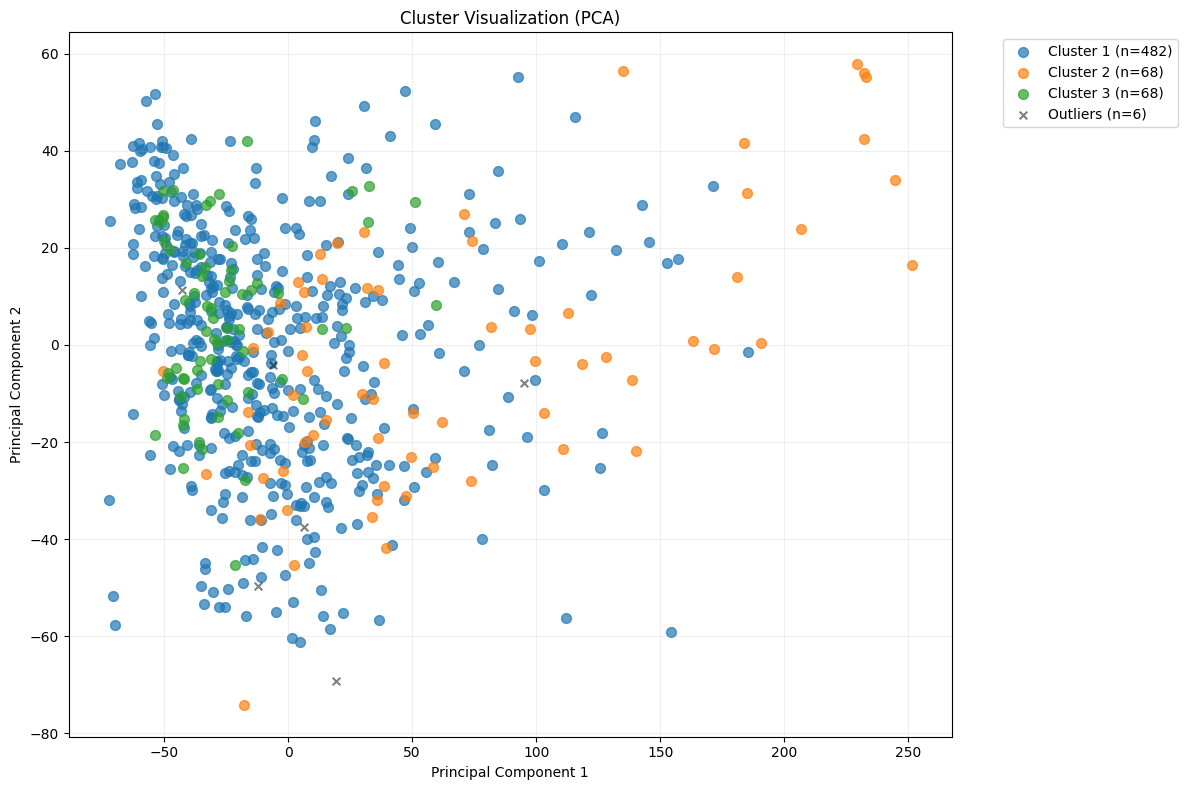

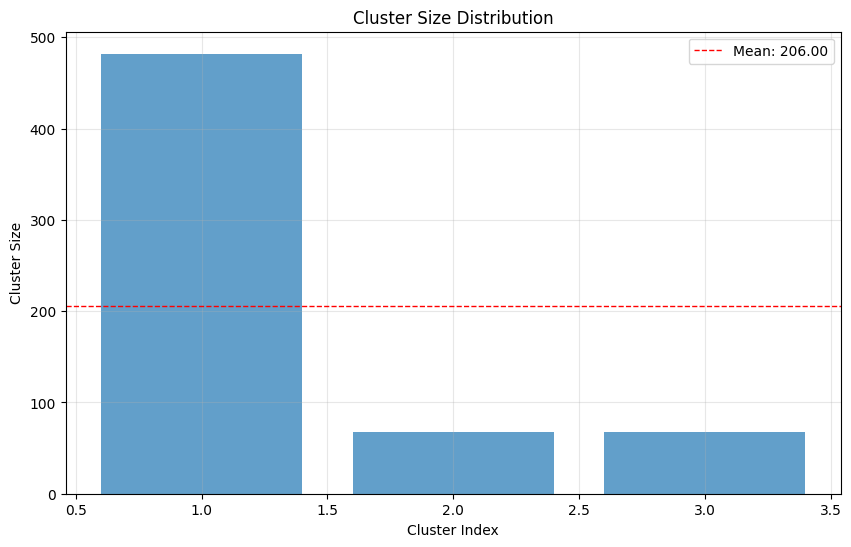

Results saved to 'balanced_clustering_results.csv'
Cluster summary saved to 'balanced_cluster_summary.csv'


In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter

def normalized_euclidean_similarity(X):
    """Compute similarity matrix based on normalized Euclidean distance"""
    # Normalize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Compute Euclidean distances
    distances = cdist(X_scaled, X_scaled, metric='euclidean')
    
    # Normalize distances to [0, 1]
    max_dist = np.max(distances)
    if max_dist > 0:
        normalized_dist = distances / max_dist
    else:
        normalized_dist = distances
    
    # Convert to similarity (1 - distance)
    similarity = 1 - normalized_dist
    return similarity

def build_initial_clusters(similarity_matrix, r=0.85):
    """Identify neighbors based on similarity threshold"""
    n_samples = similarity_matrix.shape[0]
    clusters = []
    densities = []
    
    for i in range(n_samples):
        neighbors = np.where(similarity_matrix[i] >= r)[0]
        clusters.append(neighbors)
        densities.append(len(neighbors))
    
    return clusters, densities

def hierarchical_cluster_merging(clusters, similarity_matrix, initial_threshold=0.4, min_threshold=0.2, step=0.05):
    """
    Hierarchical merging of clusters starting with a higher threshold
    and gradually reducing until a target number of clusters is reached
    """
    if len(clusters) <= 4:  # If already few clusters, no need to merge
        return clusters
    
    merged = clusters.copy()
    current_threshold = initial_threshold
    
    while current_threshold >= min_threshold and len(merged) > 4:
        # Try to merge at current threshold
        merged = merge_overlapping_clusters(merged, similarity_matrix, current_threshold)
        
        # If we still have too many clusters, reduce threshold and try again
        if len(merged) > 10:
            current_threshold -= step
        else:
            break
    
    return merged

def merge_overlapping_clusters(clusters, similarity_matrix, overlap_threshold=0.4):
    """
    Merge clusters that share significant similarities
    """
    if len(clusters) <= 1:
        return clusters
    
    merged_clusters = []
    used_indices = set()
    
    # Sort clusters by size (descending)
    clusters_with_size = [(i, len(c), c) for i, c in enumerate(clusters)]
    clusters_with_size.sort(key=lambda x: x[1], reverse=True)
    
    for i, size_i, cluster_i in clusters_with_size:
        if i in used_indices:
            continue
            
        current_merged = set(cluster_i)
        used_indices.add(i)
        
        # Look for clusters to merge with current cluster
        for j, size_j, cluster_j in clusters_with_size:
            if j in used_indices:
                continue
                
            # Calculate similarity between clusters
            similarity_score = calculate_cluster_similarity(cluster_i, cluster_j, similarity_matrix)
            
            if similarity_score >= overlap_threshold:
                current_merged.update(cluster_j)
                used_indices.add(j)
        
        merged_clusters.append(list(current_merged))
    
    # Add any remaining clusters
    for i, size, cluster in clusters_with_size:
        if i not in used_indices:
            merged_clusters.append(cluster)
            used_indices.add(i)
    
    return merged_clusters

def calculate_cluster_similarity(cluster1, cluster2, similarity_matrix):
    """
    Calculate the average similarity between two clusters
    """
    if len(cluster1) == 0 or len(cluster2) == 0:
        return 0.0
    
    total_similarity = 0.0
    count = 0
    
    # Sample up to 20 points from each cluster to speed up calculation for large clusters
    sample1 = cluster1 if len(cluster1) <= 20 else np.random.choice(cluster1, 20, replace=False)
    sample2 = cluster2 if len(cluster2) <= 20 else np.random.choice(cluster2, 20, replace=False)
    
    for i in sample1:
        for j in sample2:
            total_similarity += similarity_matrix[i, j]
            count += 1
    
    return total_similarity / count if count > 0 else 0.0

# 5. Fix the assign_samples_to_best_clusters function
def assign_samples_to_best_clusters(clusters, similarity_matrix):
    """
    Ensure each sample is assigned to exactly one best-fitting cluster
    with improved controls
    """
    n_samples = similarity_matrix.shape[0]
    final_clusters = [[] for _ in range(len(clusters))]
    sample_to_cluster = {}
    
    # First, handle samples that appear in multiple clusters
    for sample_idx in range(n_samples):
        # Find all clusters containing this sample
        containing_clusters = []
        for cluster_idx, cluster in enumerate(clusters):
            if sample_idx in cluster:
                containing_clusters.append(cluster_idx)
        
        if not containing_clusters:
            continue  # Will handle unassigned points later
        
        # Find best fitting cluster
        best_cluster_idx = -1
        best_avg_similarity = -1
        
        for cluster_idx in containing_clusters:
            cluster = clusters[cluster_idx]
            similarities = []
            
            for other_sample in cluster:
                if other_sample != sample_idx:
                    similarities.append(similarity_matrix[sample_idx, other_sample])
            
            if similarities:
                avg_similarity = sum(similarities) / len(similarities)
                if avg_similarity > best_avg_similarity:
                    best_avg_similarity = avg_similarity
                    best_cluster_idx = cluster_idx
        
        if best_cluster_idx >= 0:
            final_clusters[best_cluster_idx].append(sample_idx)
            sample_to_cluster[sample_idx] = best_cluster_idx
    
    # Next, assign unassigned samples to closest cluster
    unassigned = set(range(n_samples)) - set(sample_to_cluster.keys())
    
    # CHANGE: Improve unassigned sample handling
    for sample_idx in unassigned:
        best_cluster_idx = -1
        best_avg_similarity = -1
        
        for cluster_idx, cluster in enumerate(final_clusters):
            if not cluster:  # Skip empty clusters
                continue
                
            # Sample a subset of points for large clusters
            sample_size = min(len(cluster), 30)  # Cap at 30 samples for efficiency
            if len(cluster) > sample_size:
                sample_points = np.random.choice(cluster, sample_size, replace=False)
            else:
                sample_points = cluster
                
            similarities = [similarity_matrix[sample_idx, other] for other in sample_points]
            if similarities:
                avg_similarity = sum(similarities) / len(similarities)
                if avg_similarity > best_avg_similarity:
                    best_avg_similarity = avg_similarity
                    best_cluster_idx = cluster_idx
        
        # CHANGE: Adjust threshold for assignment (0.4 to 0.5)
        if best_cluster_idx >= 0 and best_avg_similarity > 0.5:  # Stricter assignment
            final_clusters[best_cluster_idx].append(sample_idx)
            sample_to_cluster[sample_idx] = best_cluster_idx
    
    # Remove any empty clusters
    final_clusters = [cluster for cluster in final_clusters if cluster]
    
    # Recalculate assignments after removing empty clusters
    cluster_assignments = {}
    for new_idx, cluster in enumerate(final_clusters):
        for sample in cluster:
            cluster_assignments[sample] = new_idx
    
    # Identify outliers
    all_assigned = set(cluster_assignments.keys())
    outliers = list(set(range(n_samples)) - all_assigned)
    
    return final_clusters, cluster_assignments, outliers

# 3. Fix the balance_clusters function
def balance_clusters(clusters, similarity_matrix, min_size=20, target_clusters=6):  # Changed min_size from 8 to 20
    """
    Balance cluster sizes with better controls
    """
    n_samples = similarity_matrix.shape[0]
    
    # Sort clusters by size
    clusters_with_size = [(i, len(c), c) for i, c in enumerate(clusters)]
    clusters_with_size.sort(key=lambda x: x[1], reverse=True)
    
    # CHANGE: Better parameters for splitting large clusters
    balanced_clusters = []
    
    for i, size, cluster in clusters_with_size:
        # CHANGE: Lower the threshold from 35% to 25%
        if size > n_samples * 0.25:  # Split clusters containing more than 25% of samples
            # CHANGE: Split into more subclusters (3 instead of 2)
            subclusters = split_large_cluster(cluster, similarity_matrix, n_subclusters=3)
            balanced_clusters.extend(subclusters)
        elif size < min_size and len(clusters) > target_clusters:
            # Small clusters will be merged later or treated as outliers
            pass
        else:
            balanced_clusters.append(cluster)
    
    # CHANGE: More controlled merging of small clusters
    if len(balanced_clusters) > target_clusters:
        small_clusters = [c for c in balanced_clusters if len(c) < min_size]
        large_clusters = [c for c in balanced_clusters if len(c) >= min_size]
        
        for small_cluster in small_clusters:
            if not small_cluster:
                continue
                
            best_match = -1
            best_similarity = -1
            
            for i, large_cluster in enumerate(large_clusters):
                sim = calculate_cluster_similarity(small_cluster, large_cluster, similarity_matrix)
                if sim > best_similarity:
                    best_similarity = sim
                    best_match = i
            
            # CHANGE: Increase similarity threshold from 0.3 to 0.4
            if best_match >= 0 and best_similarity > 0.4:
                large_clusters[best_match].extend(small_cluster)
            else:
                large_clusters.append(small_cluster)  # Keep as separate if no good match
        
        balanced_clusters = large_clusters
    
    return balanced_clusters

# 4. Fix the split_large_cluster function
def split_large_cluster(cluster, similarity_matrix, n_subclusters=3):  # Changed from 2 to 3
    """
    Split a large cluster into subclusters with improved algorithm
    """
    if len(cluster) <= 10:  # Don't split small clusters
        return [cluster]
    
    # CHANGE: Better centroid selection
    # Select initial centroids as most distant points
    centroid_indices = [cluster[0]]
    
    for _ in range(n_subclusters - 1):
        # Find point with maximum distance to current centroids
        max_min_distance = -1
        next_centroid = -1
        
        for idx in cluster:
            if idx in centroid_indices:
                continue
                
            # Find minimum similarity to any existing centroid
            min_similarity = min(similarity_matrix[idx, centroid] for centroid in centroid_indices)
            
            if 1 - min_similarity > max_min_distance:  # Convert similarity to distance
                max_min_distance = 1 - min_similarity
                next_centroid = idx
        
        if next_centroid >= 0:
            centroid_indices.append(next_centroid)
    
    # CHANGE: Use soft assignment with minimum cluster size
    # Create initial subclusters
    subclusters = [[] for _ in range(n_subclusters)]
    
    # First, assign each point to the closest centroid
    for idx in cluster:
        similarities = [similarity_matrix[idx, centroid] for centroid in centroid_indices]
        best_centroid = np.argmax(similarities)
        subclusters[best_centroid].append(idx)
    
    # Ensure minimum size by redistributing points from large to small clusters
    min_subcluster_size = max(5, len(cluster) // (n_subclusters * 3))
    
    # Check if any subcluster is too small
    for i in range(n_subclusters):
        if len(subclusters[i]) < min_subcluster_size:
            # Find largest subcluster
            largest_idx = np.argmax([len(sc) for sc in subclusters])
            
            if largest_idx != i and len(subclusters[largest_idx]) > 2 * min_subcluster_size:
                # Move points from largest to this small subcluster
                # Find points in largest cluster closest to this centroid
                candidates = []
                
                for idx in subclusters[largest_idx]:
                    sim_to_small = similarity_matrix[idx, centroid_indices[i]]
                    candidates.append((idx, sim_to_small))
                
                # Sort by similarity to small cluster's centroid
                candidates.sort(key=lambda x: x[1], reverse=True)
                
                # Move enough points to reach minimum size
                points_to_move = min_subcluster_size - len(subclusters[i])
                points_to_move = min(points_to_move, len(candidates) // 2)  # Don't move too many
                
                for j in range(points_to_move):
                    idx_to_move = candidates[j][0]
                    subclusters[i].append(idx_to_move)
                    subclusters[largest_idx].remove(idx_to_move)
    
    # Return only non-empty subclusters
    return [subcluster for subcluster in subclusters if subcluster]


def improved_clustering_pipeline(data, target_clusters=6):
    """
    Enhanced clustering pipeline with balanced cluster sizes
    """
    print("Step 1: Computing similarity matrix...")
    similarity = normalized_euclidean_similarity(data)
    
    print("Step 2: Building initial clusters...")
    initial_clusters, densities = build_initial_clusters(similarity, r=0.85)
    
    print("Step 3: Merging overlapping clusters...")
    merged_clusters = hierarchical_cluster_merging(initial_clusters, similarity,
                                                initial_threshold=0.4,
                                                min_threshold=0.2,
                                                step=0.05)
    
    print("Step 4: Balancing cluster sizes...")
    balanced_clusters = balance_clusters(merged_clusters, similarity, 
                                      min_size=8, 
                                      target_clusters=target_clusters)
    
    print("Step 5: Assigning samples to best-fitting clusters...")
    final_clusters, cluster_assignments, outliers = assign_samples_to_best_clusters(
        balanced_clusters, similarity
    )
    
    # Print summary statistics
    print(f"\nClustering Results:")
    print(f"  Initial clusters: {len(initial_clusters)}")
    print(f"  After merging: {len(merged_clusters)}")
    print(f"  After balancing: {len(balanced_clusters)}")
    print(f"  Final clusters: {len(final_clusters)}")
    print(f"  Total samples: {data.shape[0]}")
    print(f"  Samples in clusters: {data.shape[0] - len(outliers)}")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/data.shape[0]*100:.2f}%)")
    
    # Show cluster size distribution
    cluster_sizes = [len(cluster) for cluster in final_clusters]
    print(f"\nCluster size distribution:")
    print(f"  Min size: {min(cluster_sizes) if cluster_sizes else 0}")
    print(f"  Max size: {max(cluster_sizes) if cluster_sizes else 0}")
    print(f"  Average size: {sum(cluster_sizes)/len(cluster_sizes) if cluster_sizes else 0:.2f}")
    print(f"  Cluster sizes: {sorted(cluster_sizes, reverse=True)}")
    
    return final_clusters, cluster_assignments, outliers, similarity

def visualize_clustering_results(data, final_clusters, outliers, cluster_assignments):
    """
    Visualize the clustering results using PCA
    """
    # Use PCA to reduce dimensions for visualization
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    
    # Create a colormap for the clusters
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab10')  # 10 distinct colors
    colors = [cmap(i % 10) for i in range(len(final_clusters))]
    
    # Plot clusters and outliers
    plt.figure(figsize=(12, 8))
    
    # Plot each cluster
    for idx, cluster in enumerate(final_clusters):
        if cluster:
            cluster_points = data_2d[cluster]
            plt.scatter(
                cluster_points[:, 0], 
                cluster_points[:, 1], 
                color=colors[idx], 
                alpha=0.7, 
                s=50, 
                label=f'Cluster {idx+1} (n={len(cluster)})'
            )
    
    # Plot outliers
    if outliers:
        outlier_points = data_2d[outliers]
        plt.scatter(
            outlier_points[:, 0], 
            outlier_points[:, 1], 
            color='black', 
            marker='x', 
            alpha=0.5, 
            s=30, 
            label=f'Outliers (n={len(outliers)})'
        )
    
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()
    
    # Plot cluster size distribution
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(final_clusters)+1), [len(c) for c in final_clusters], alpha=0.7)
    avg_size = np.mean([len(c) for c in final_clusters])
    plt.axhline(avg_size, color='r', linestyle='dashed', linewidth=1,
               label=f'Mean: {avg_size:.2f}')
    plt.xlabel('Cluster Index')
    plt.ylabel('Cluster Size')
    plt.title('Cluster Size Distribution')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def run_clustering_analysis(data_path, target_clusters=6):
    """
    Main function to run the complete clustering pipeline
    """
    # Load and preprocess data
    print("Loading data...")
    data = pd.read_csv(data_path)
    
    # Data preprocessing as in your original code
    data = data.dropna(axis=1)
    data = data.loc[:, ~data.columns.duplicated()]
    data = data.apply(pd.to_numeric, errors='coerce')
    data = data.dropna()
    
    # Extract labels and features
    labels = data.iloc[:, -1].values if data.shape[1] > 1 else None
    features_df = data.drop(data.columns[-1], axis=1) if data.shape[1] > 1 else data
    
    print(f"Data loaded with shape: {data.shape}")
    print(f"Features shape: {features_df.shape}")
    
    # Run clustering with target number of clusters
    final_clusters, cluster_assignments, outliers, similarity = improved_clustering_pipeline(
        features_df.values, target_clusters=target_clusters
    )
    
    # Visualize results
    try:
        visualize_clustering_results(features_df.values, final_clusters, outliers, cluster_assignments)
    except ImportError:
        print("Visualization libraries not available. Skipping visualization.")
    
    # Save results to CSV
    save_clustering_results(data, final_clusters, outliers, cluster_assignments)
    
    return final_clusters, cluster_assignments, outliers, similarity

def save_clustering_results(data, final_clusters, outliers, cluster_assignments):
    """
    Save clustering results to CSV files
    """
    # Create DataFrame with original data and cluster assignments
    result_df = data.copy()
    
    # Add cluster assignment column
    cluster_column = [-1] * len(data)  # Initialize all to -1 (outlier)
    for sample_idx, cluster_idx in cluster_assignments.items():
        cluster_column[sample_idx] = cluster_idx
    
    result_df['cluster'] = cluster_column
    
    # Save to CSV
    result_df.to_csv("balanced_clustering_results.csv", index=False)
    print("Results saved to 'balanced_clustering_results.csv'")
    
    # Save cluster summary
    cluster_summary = []
    for cluster_idx, cluster in enumerate(final_clusters):
        cluster_summary.append({
            'cluster_id': cluster_idx,
            'size': len(cluster),
            'samples': str(sorted(cluster))
        })
    
    summary_df = pd.DataFrame(cluster_summary)
    summary_df.to_csv("balanced_cluster_summary.csv", index=False)
    print("Cluster summary saved to 'balanced_cluster_summary.csv'")

# Example usage
if __name__ == "__main__":
    # Replace with your data path
    final_clusters, cluster_assignments, outliers, similarity = run_clustering_analysis(
        "../data/vpufs_reduced_features.csv", 
        target_clusters=6  # Target 6 clusters
    )